In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [27]:
cols = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class']
df = pd.read_csv('magic+gamma+telescope/magic04.data' ,names=cols)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [28]:
df['class'] = (df['class'] == "g").astype(int)

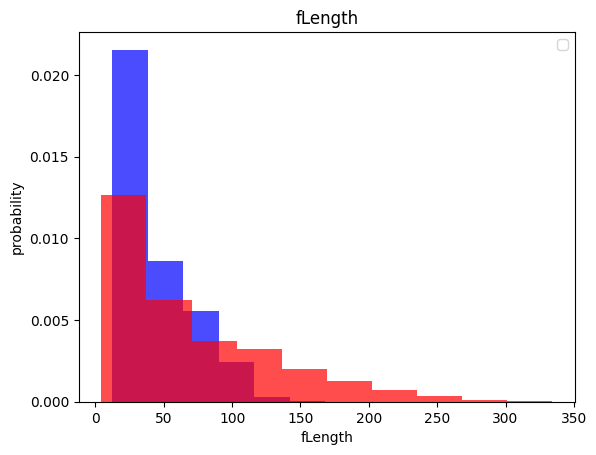

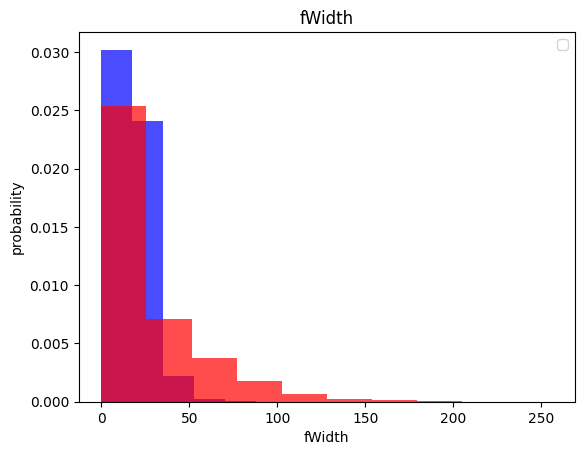

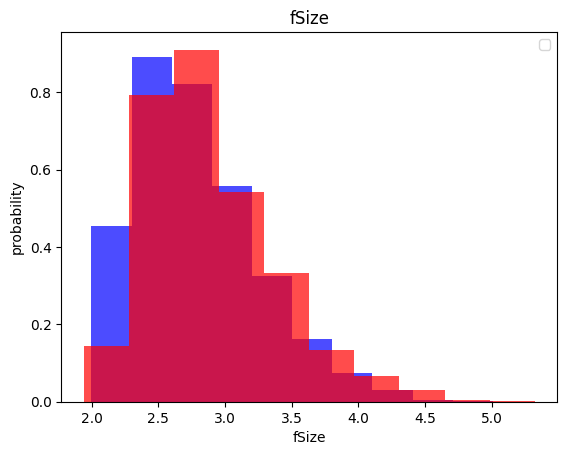

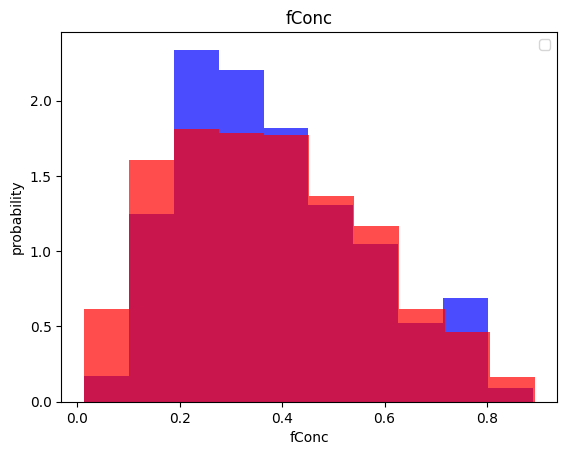

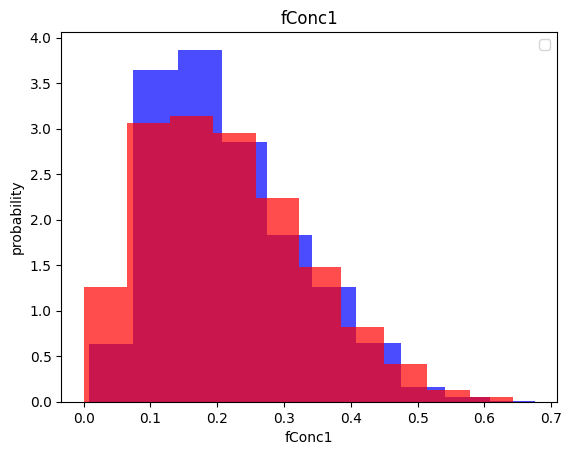

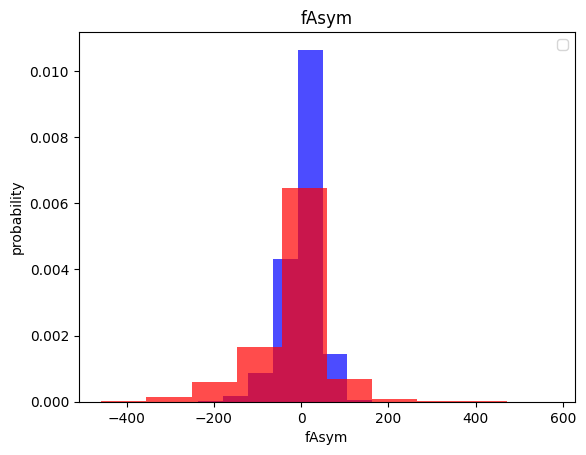

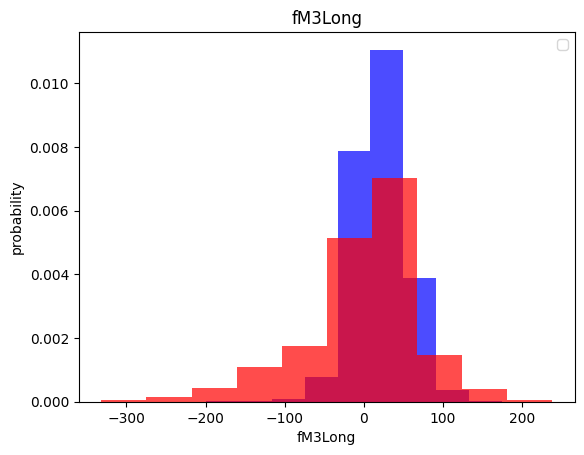

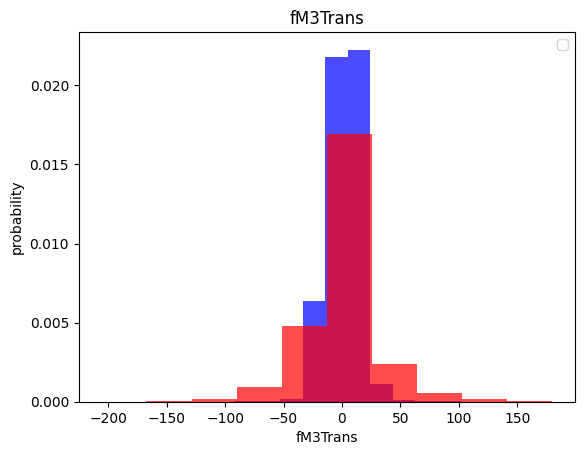

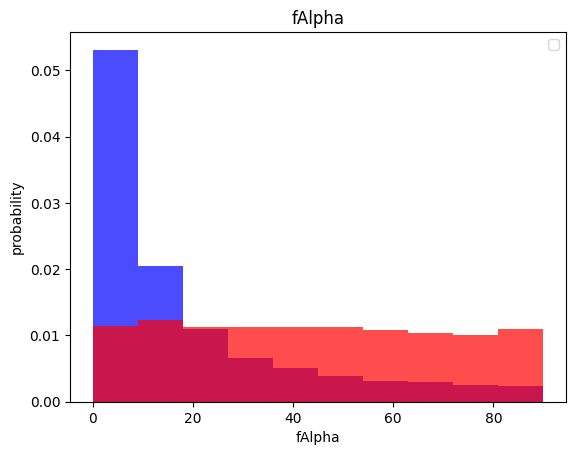

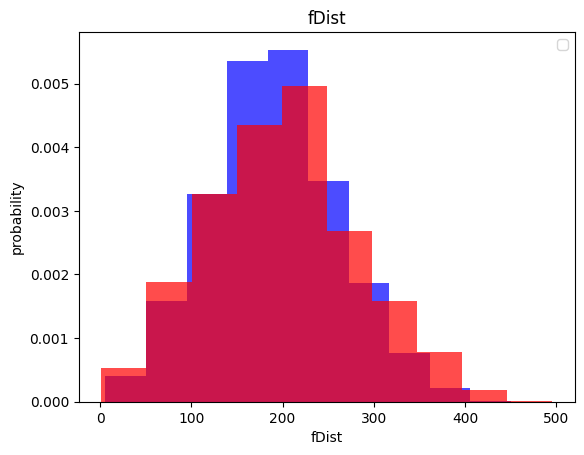

In [29]:
for label in cols[:-1]:
    plt.hist(df[df['class'] ==1][label],color='blue',label='gamma' , alpha=0.7 , density=True)
    plt.hist(df[df['class'] ==0][label],color='red',label='hadron' , alpha=0.7 , density=True)
    plt.title(label)
    plt.ylabel('probability')
    plt.xlabel(label)
    plt.legend('')
    plt.show()

# Train, validation and test datasets

In [30]:
train , valid , test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [31]:
print(len(train[train['class'] ==1 ])) # gamma
print(len(train[train['class'] ==0 ])) # hadron

7357
4055


In [32]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # increase the size of the dataset of the small class
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
    
    data = np.hstack((X,np.reshape(y, (-1,1))))

    return data, X, y

In [33]:
train, X_train, y_train = scale_dataset(train,oversample=True)
valid, X_valid, y_valid = scale_dataset(valid,oversample=False)
test, X_test,y_test = scale_dataset(test,oversample=False)


# kNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [35]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [36]:
y_pred = knn_model.predict(X_test)

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1344
           1       0.83      0.88      0.86      2460

    accuracy                           0.81      3804
   macro avg       0.79      0.78      0.78      3804
weighted avg       0.80      0.81      0.80      3804



# Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train,y_train)

In [40]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.42      0.53      1344
           1       0.74      0.92      0.82      2460

    accuracy                           0.74      3804
   macro avg       0.74      0.67      0.67      3804
weighted avg       0.74      0.74      0.72      3804



# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train,y_train)

In [43]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1344
           1       0.85      0.84      0.84      2460

    accuracy                           0.80      3804
   macro avg       0.78      0.78      0.78      3804
weighted avg       0.80      0.80      0.80      3804



# Support Vector Machines

In [44]:
from sklearn.svm import SVC

In [45]:
svm_model = SVC()
svm_model = svm_model.fit(X_train,y_train)

In [46]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1344
           1       0.90      0.90      0.90      2460

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.85      3804
weighted avg       0.87      0.87      0.87      3804



# Neural Net

In [47]:
import tensorflow as tf

In [48]:
def plot_history(history):
    fig ,(ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'],label='accuracy')
    ax2.plot(history.history['val_accuracy'],label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

In [49]:
def train_model(X_train,y_train,num_nodes, dropout_prob, lr , batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation = 'relu' , input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation = 'relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

    history = nn_model.fit(
        # verbose = 0 => don't show the execution process
        X_train,y_train,epochs=epochs , batch_size=batch_size , validation_split=0.2 , verbose=0
    )
    
    return nn_model, history

16 nodes, dropout 0, lr 0.01, batchsize 32


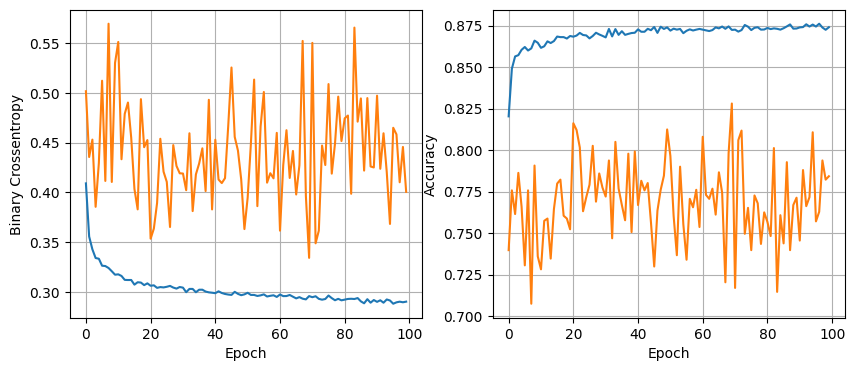

119/119 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.8630
16 nodes, dropout 0, lr 0.01, batchsize 64


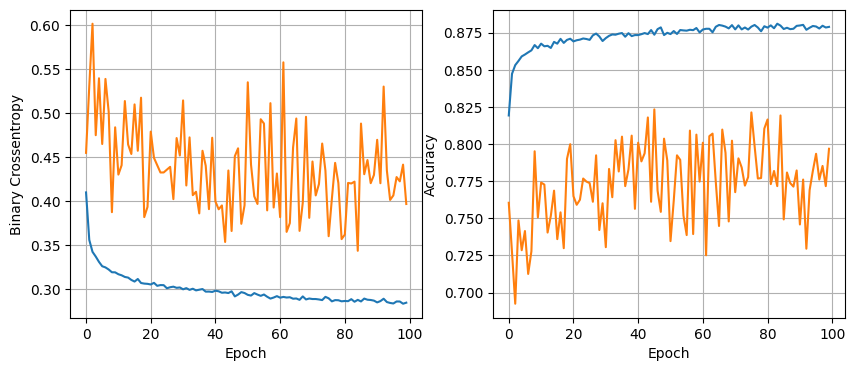

119/119 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8646
16 nodes, dropout 0, lr 0.01, batchsize 128


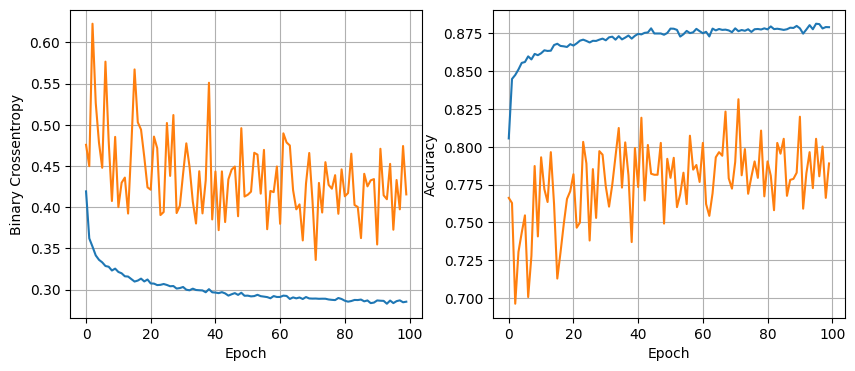

119/119 [==============================] - 0s 3ms/step - loss: 0.3241 - accuracy: 0.8657
16 nodes, dropout 0, lr 0.005, batchsize 32


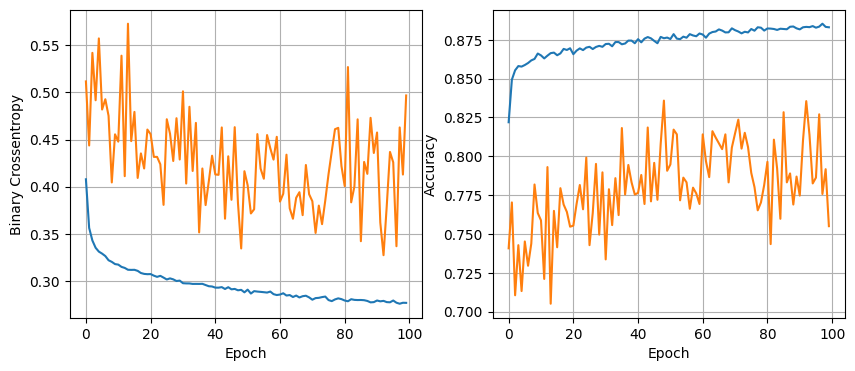

119/119 [==============================] - 0s 2ms/step - loss: 0.3189 - accuracy: 0.8688
16 nodes, dropout 0, lr 0.005, batchsize 64


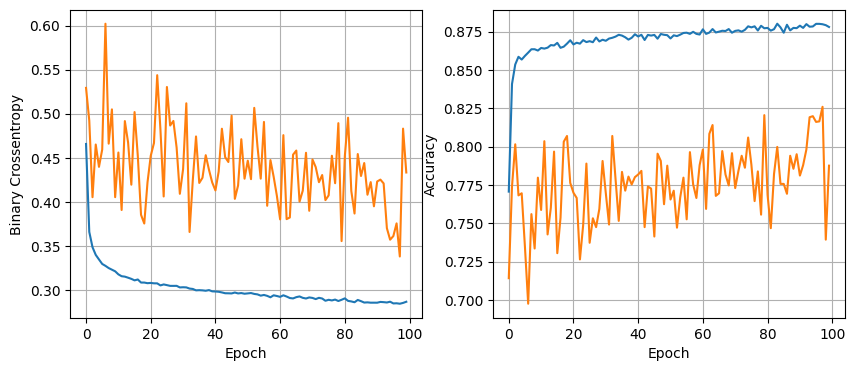

119/119 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.8712
16 nodes, dropout 0, lr 0.005, batchsize 128


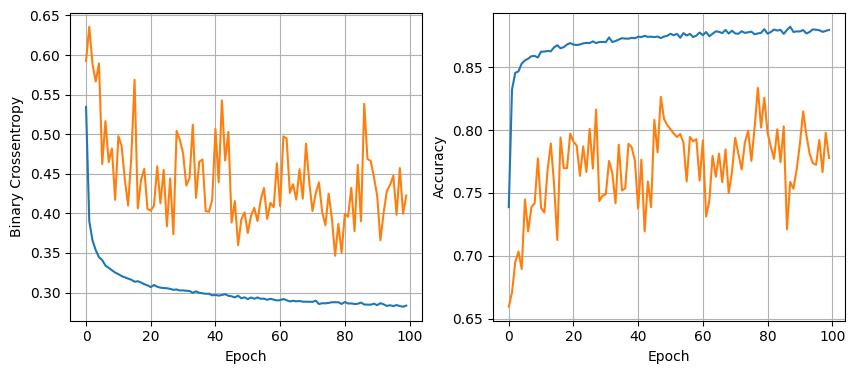

119/119 [==============================] - 0s 2ms/step - loss: 0.3173 - accuracy: 0.8670
16 nodes, dropout 0, lr 0.001, batchsize 32


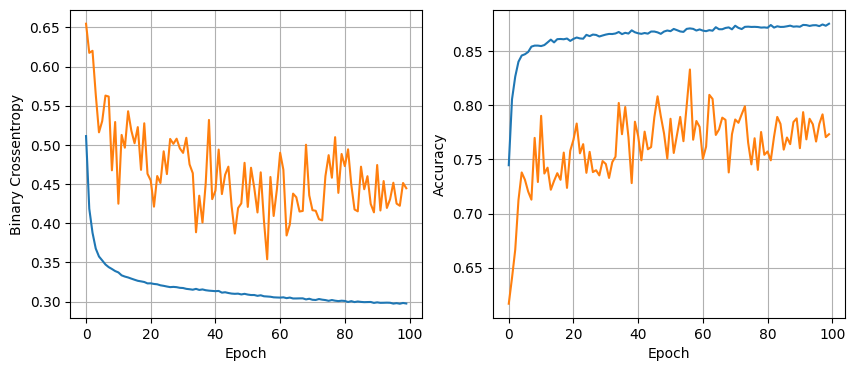

119/119 [==============================] - 0s 3ms/step - loss: 0.3169 - accuracy: 0.8675
16 nodes, dropout 0, lr 0.001, batchsize 64


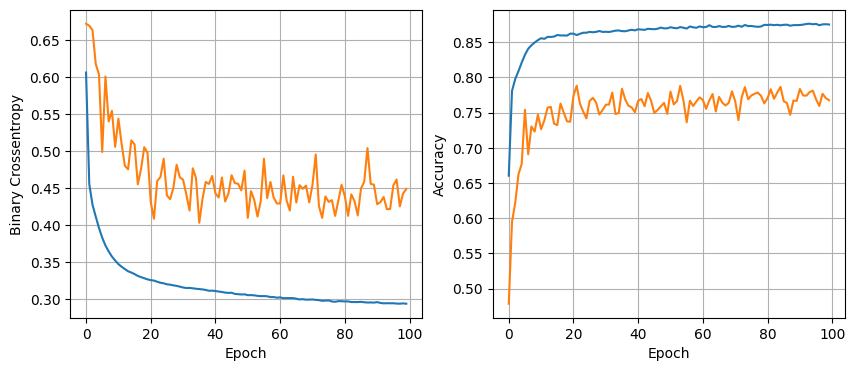

119/119 [==============================] - 0s 3ms/step - loss: 0.3092 - accuracy: 0.8725
16 nodes, dropout 0, lr 0.001, batchsize 128


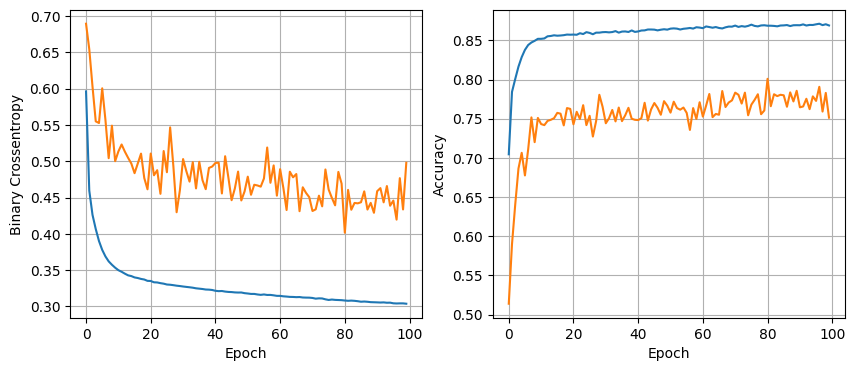

119/119 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.8691
16 nodes, dropout 0.2, lr 0.01, batchsize 32


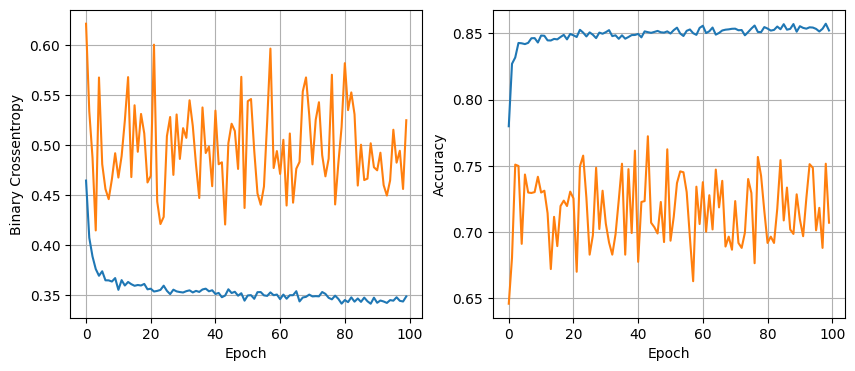

119/119 [==============================] - 0s 2ms/step - loss: 0.3095 - accuracy: 0.8688
16 nodes, dropout 0.2, lr 0.01, batchsize 64


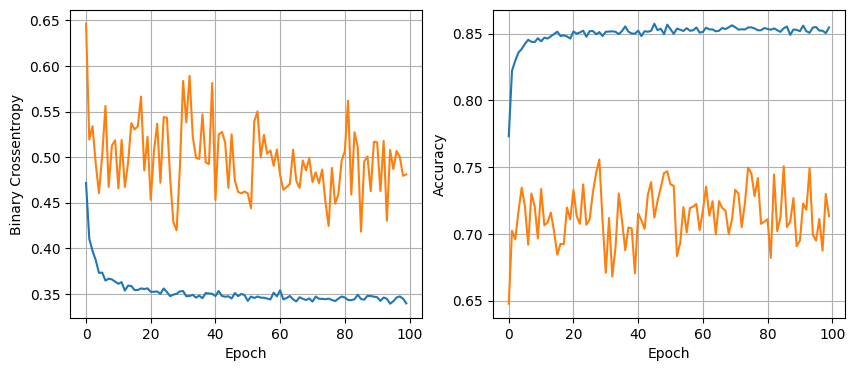

119/119 [==============================] - 0s 3ms/step - loss: 0.3122 - accuracy: 0.8720
16 nodes, dropout 0.2, lr 0.01, batchsize 128


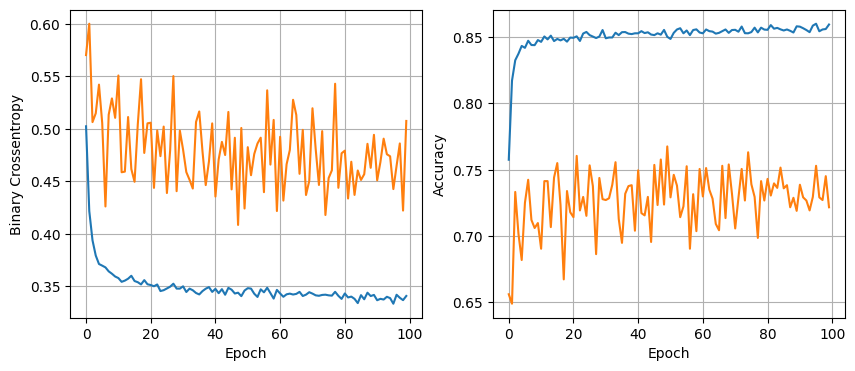

119/119 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.8730
16 nodes, dropout 0.2, lr 0.005, batchsize 32


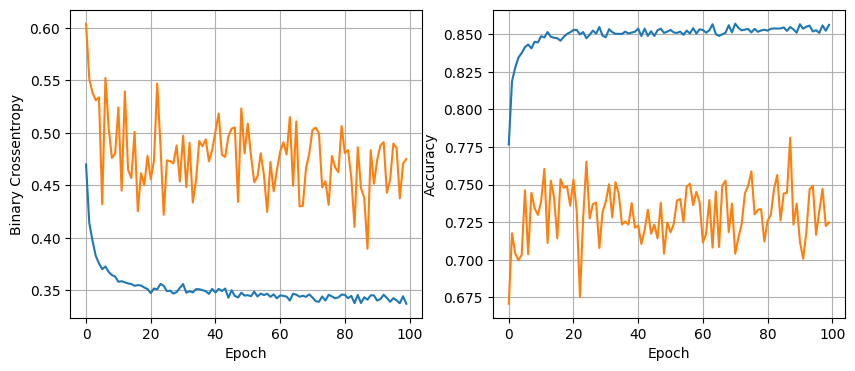

119/119 [==============================] - 1s 4ms/step - loss: 0.3138 - accuracy: 0.8675
16 nodes, dropout 0.2, lr 0.005, batchsize 64


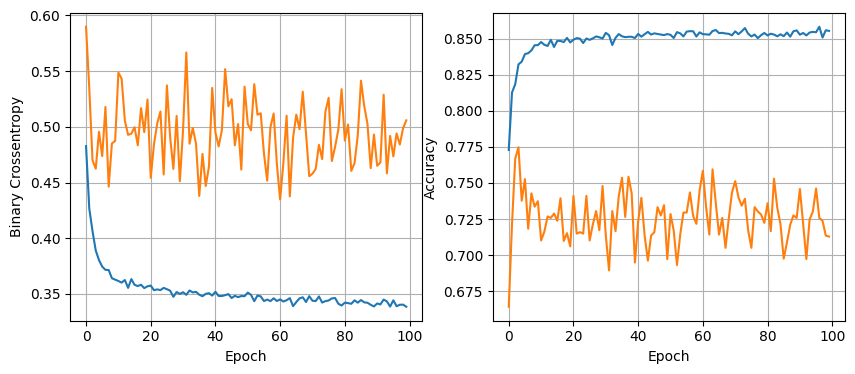

119/119 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8691
16 nodes, dropout 0.2, lr 0.005, batchsize 128


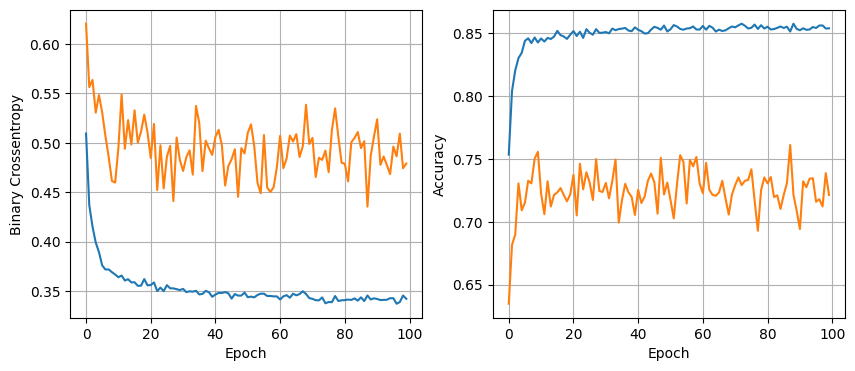

119/119 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8662
16 nodes, dropout 0.2, lr 0.001, batchsize 32


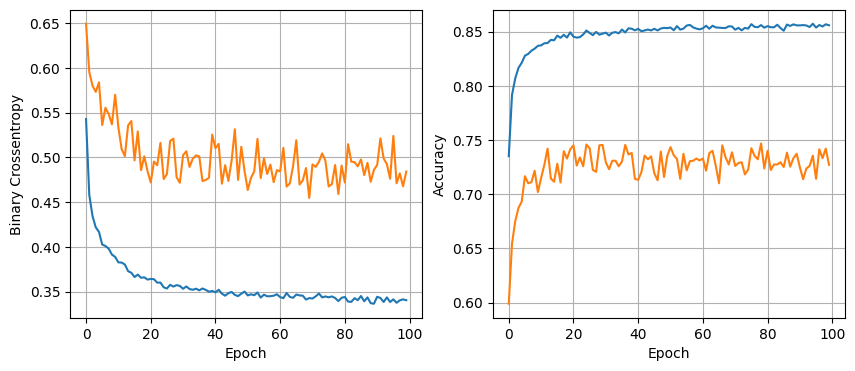

119/119 [==============================] - 0s 2ms/step - loss: 0.3118 - accuracy: 0.8717
16 nodes, dropout 0.2, lr 0.001, batchsize 64


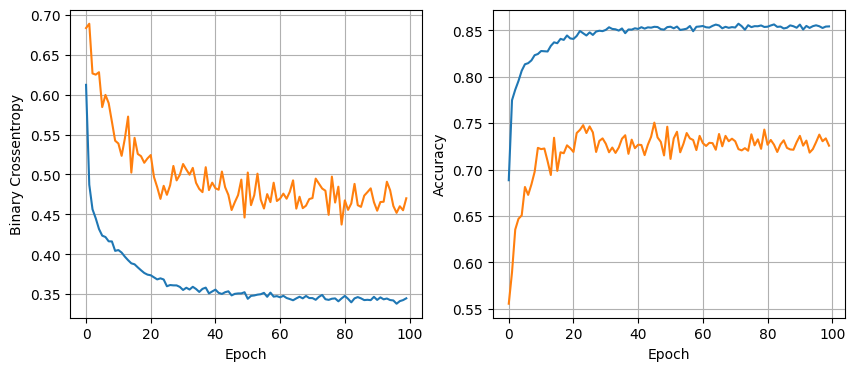

119/119 [==============================] - 0s 2ms/step - loss: 0.3133 - accuracy: 0.8738
16 nodes, dropout 0.2, lr 0.001, batchsize 128


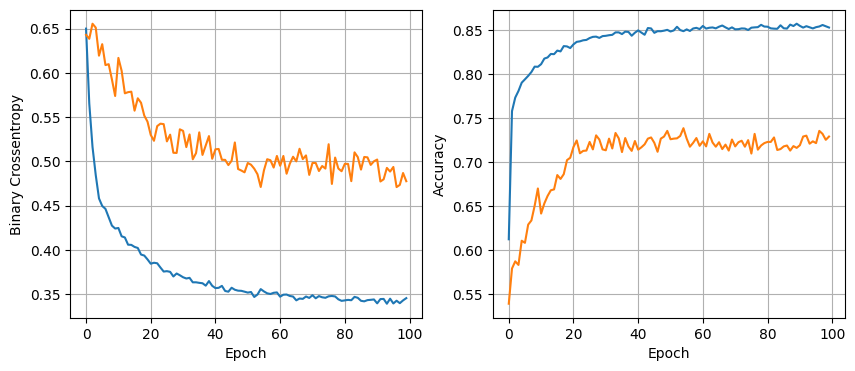

119/119 [==============================] - 0s 3ms/step - loss: 0.3093 - accuracy: 0.8728
32 nodes, dropout 0, lr 0.01, batchsize 32


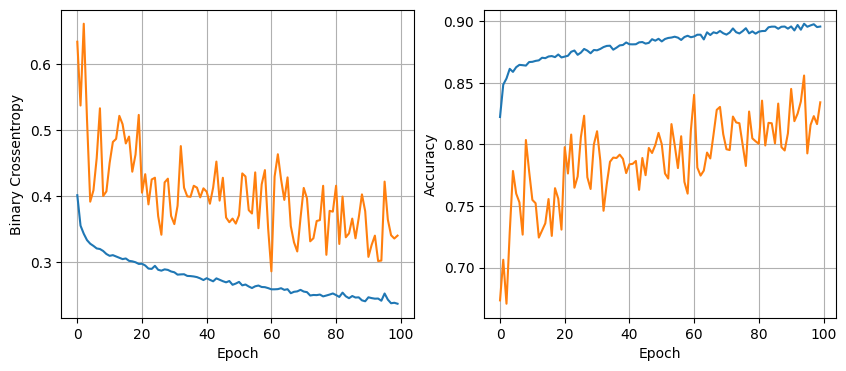

119/119 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8638
32 nodes, dropout 0, lr 0.01, batchsize 64


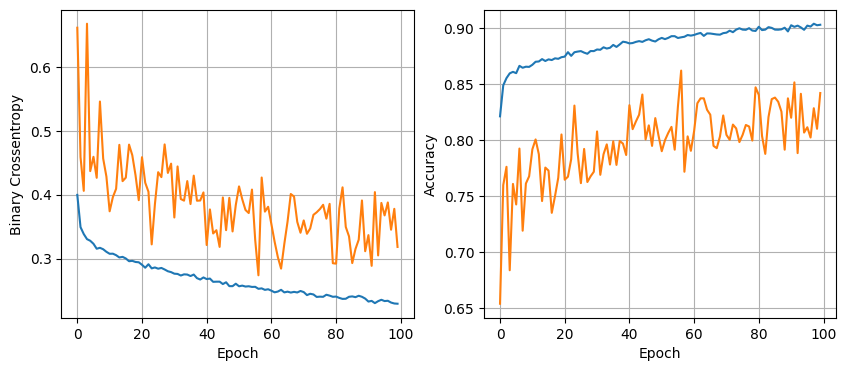

119/119 [==============================] - 1s 4ms/step - loss: 0.3827 - accuracy: 0.8659
32 nodes, dropout 0, lr 0.01, batchsize 128


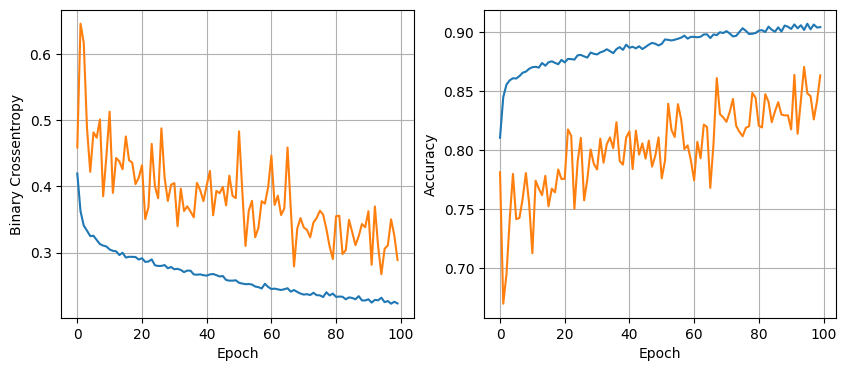

119/119 [==============================] - 0s 3ms/step - loss: 0.3617 - accuracy: 0.8649
32 nodes, dropout 0, lr 0.005, batchsize 32


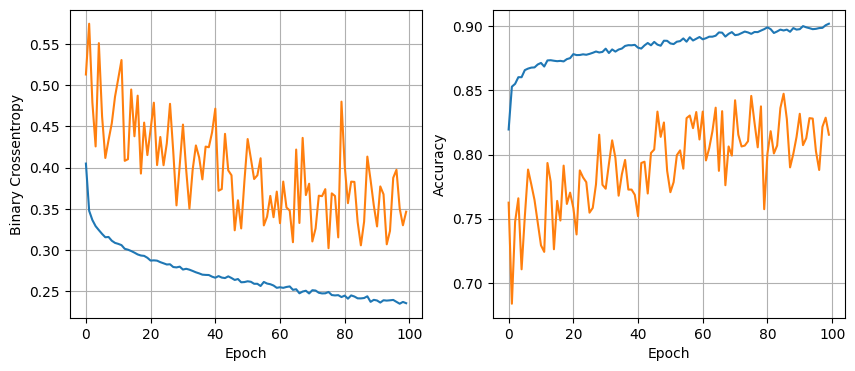

119/119 [==============================] - 0s 2ms/step - loss: 0.3809 - accuracy: 0.8630
32 nodes, dropout 0, lr 0.005, batchsize 64


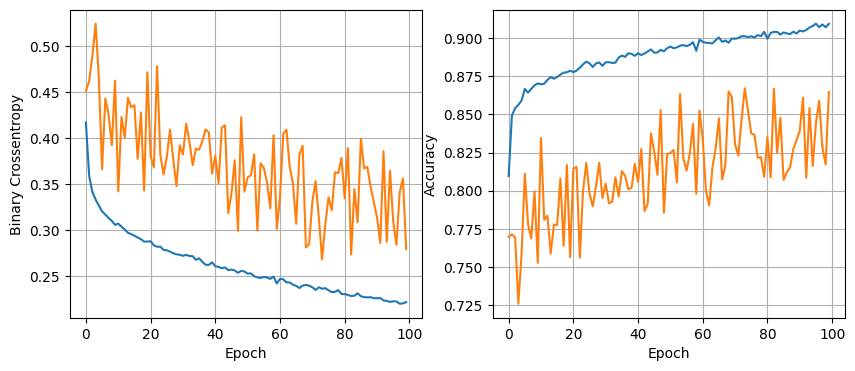

119/119 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8462
32 nodes, dropout 0, lr 0.005, batchsize 128


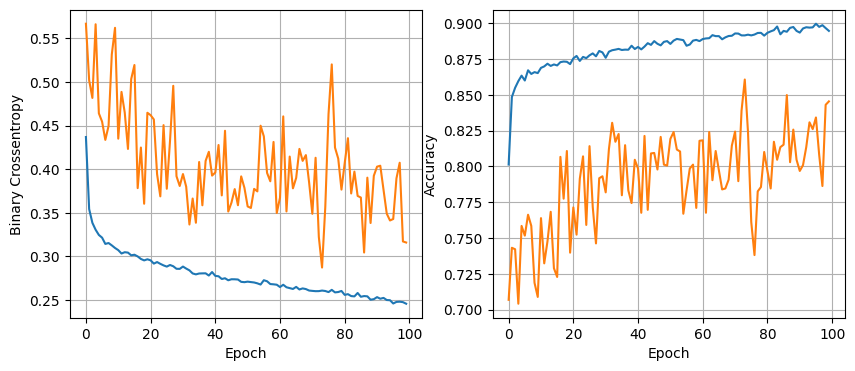

119/119 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8580
32 nodes, dropout 0, lr 0.001, batchsize 32


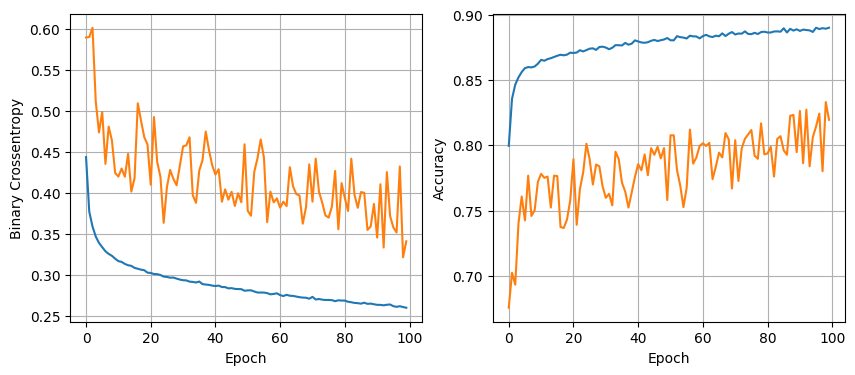

119/119 [==============================] - 0s 3ms/step - loss: 0.3331 - accuracy: 0.8609
32 nodes, dropout 0, lr 0.001, batchsize 64


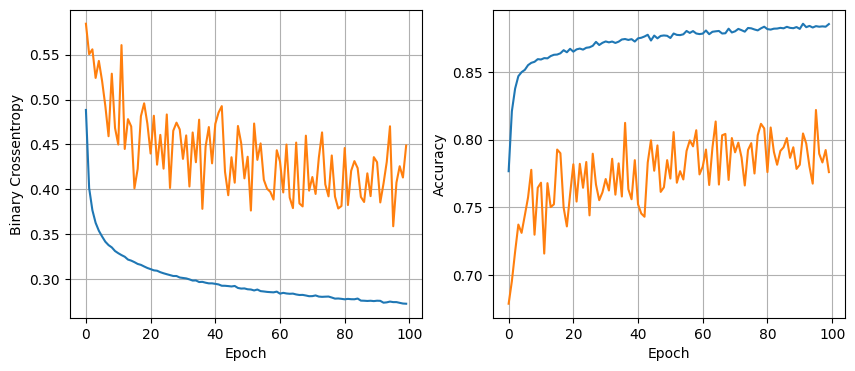

119/119 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.8712
32 nodes, dropout 0, lr 0.001, batchsize 128


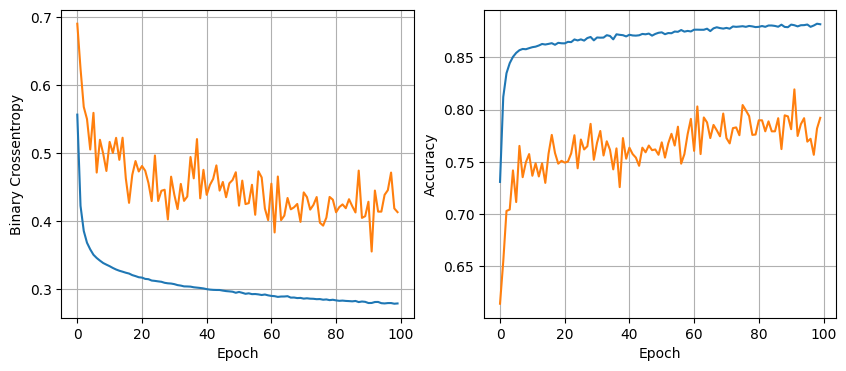

119/119 [==============================] - 0s 3ms/step - loss: 0.3081 - accuracy: 0.8688
32 nodes, dropout 0.2, lr 0.01, batchsize 32


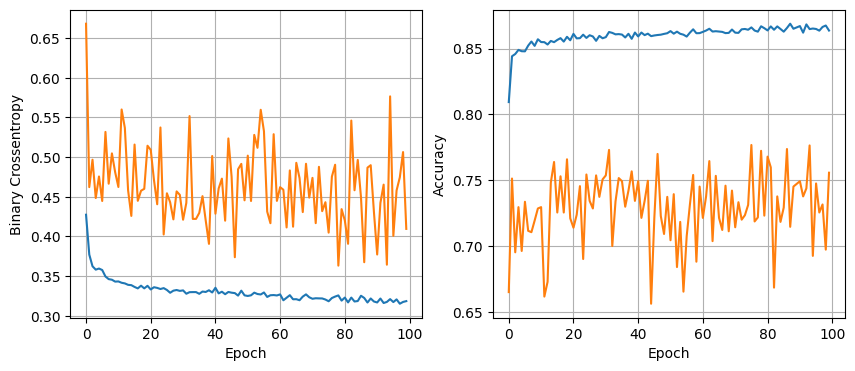

119/119 [==============================] - 0s 3ms/step - loss: 0.3059 - accuracy: 0.8709
32 nodes, dropout 0.2, lr 0.01, batchsize 64


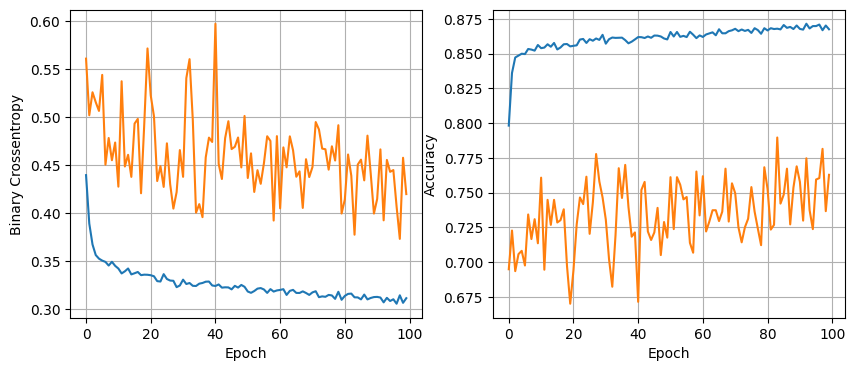

119/119 [==============================] - 0s 3ms/step - loss: 0.3059 - accuracy: 0.8754
32 nodes, dropout 0.2, lr 0.01, batchsize 128


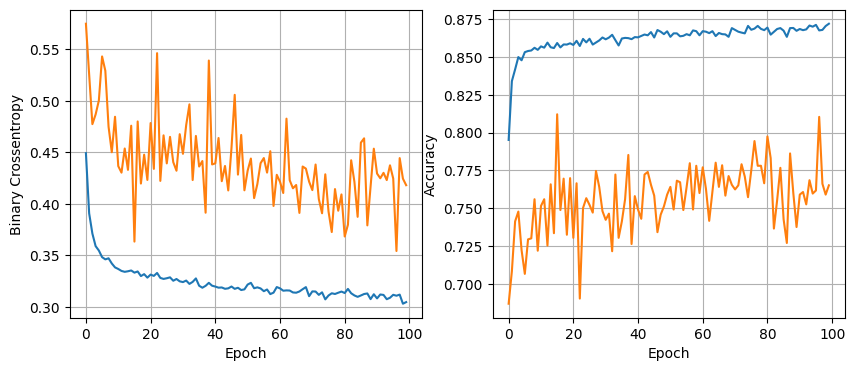

119/119 [==============================] - 0s 4ms/step - loss: 0.3026 - accuracy: 0.8785
32 nodes, dropout 0.2, lr 0.005, batchsize 32


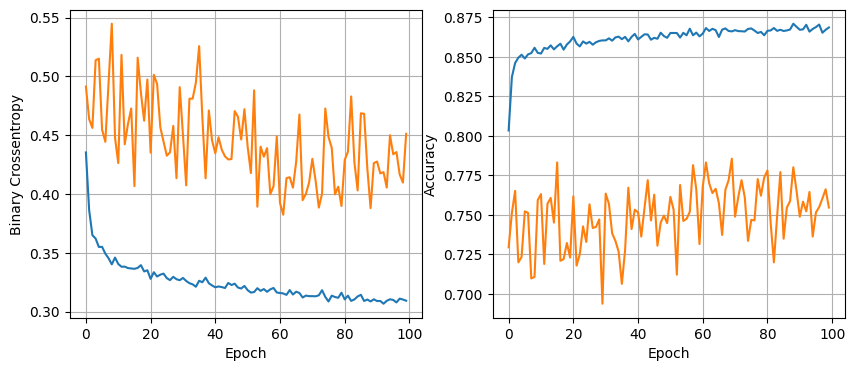

119/119 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8733
32 nodes, dropout 0.2, lr 0.005, batchsize 64


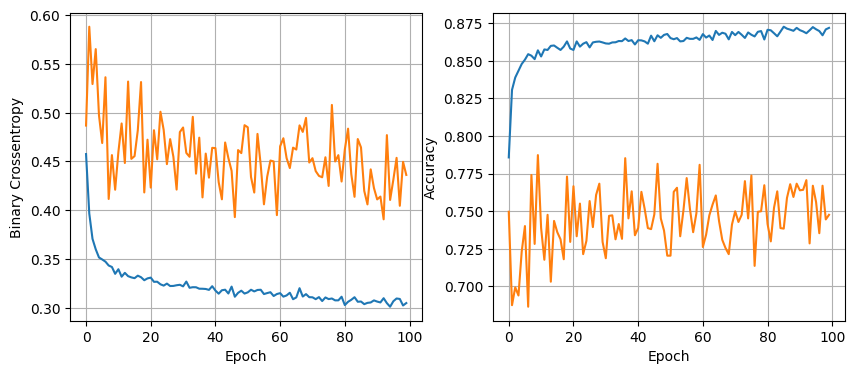

119/119 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.8728
32 nodes, dropout 0.2, lr 0.005, batchsize 128


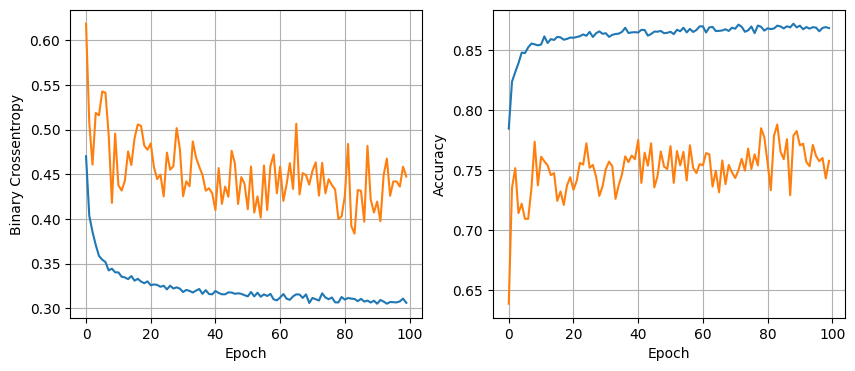

119/119 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8778
32 nodes, dropout 0.2, lr 0.001, batchsize 32


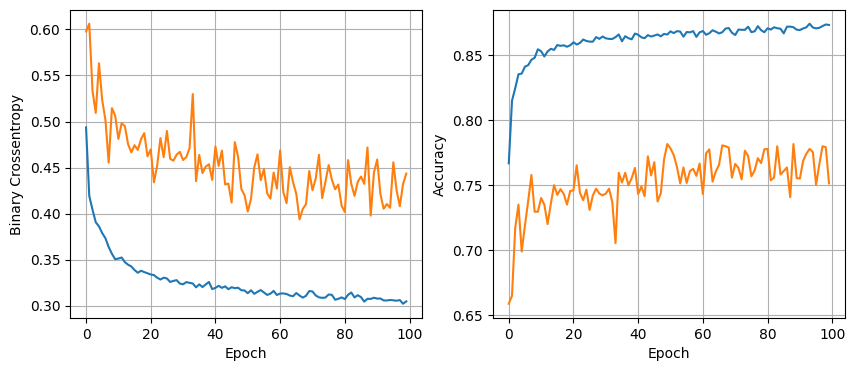

119/119 [==============================] - 0s 3ms/step - loss: 0.2960 - accuracy: 0.8767
32 nodes, dropout 0.2, lr 0.001, batchsize 64


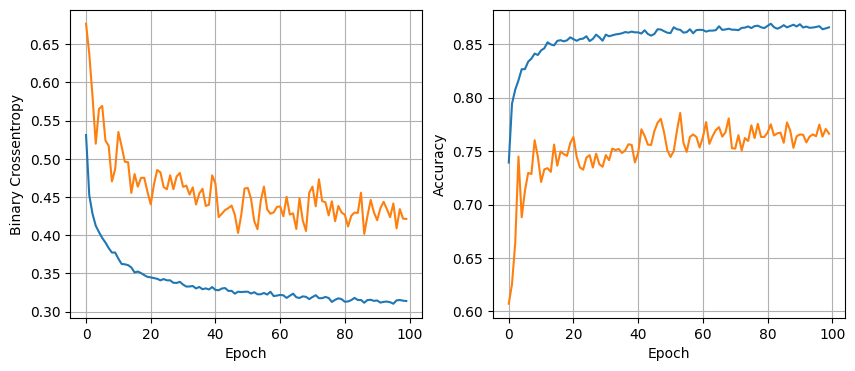

119/119 [==============================] - 0s 1ms/step - loss: 0.3008 - accuracy: 0.8754
32 nodes, dropout 0.2, lr 0.001, batchsize 128


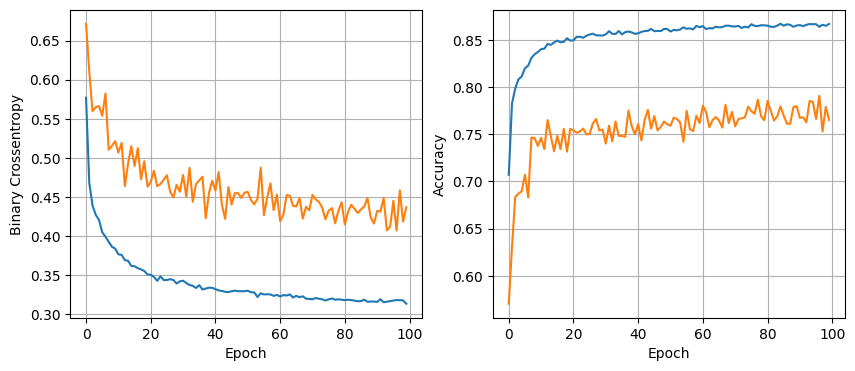

119/119 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.8733
64 nodes, dropout 0, lr 0.01, batchsize 32


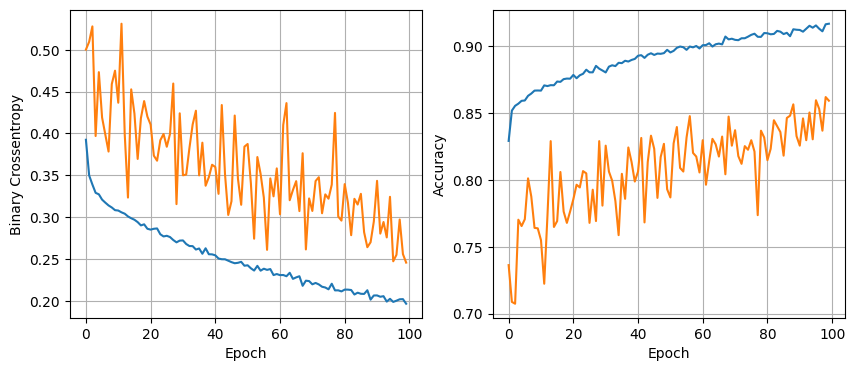

119/119 [==============================] - 0s 2ms/step - loss: 0.4935 - accuracy: 0.8607
64 nodes, dropout 0, lr 0.01, batchsize 64


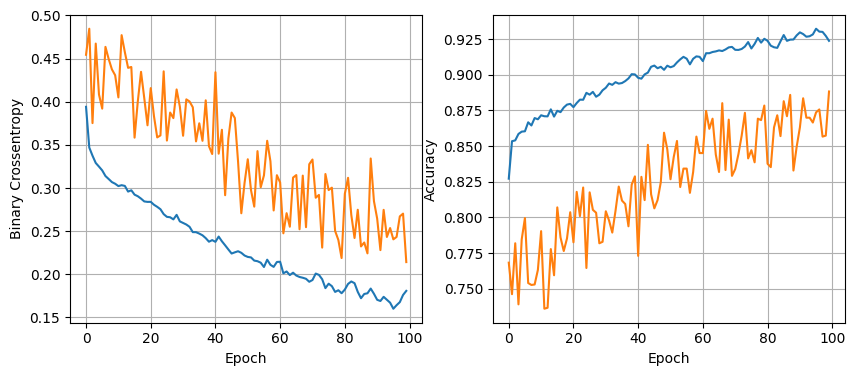

119/119 [==============================] - 0s 2ms/step - loss: 0.5270 - accuracy: 0.8554
64 nodes, dropout 0, lr 0.01, batchsize 128


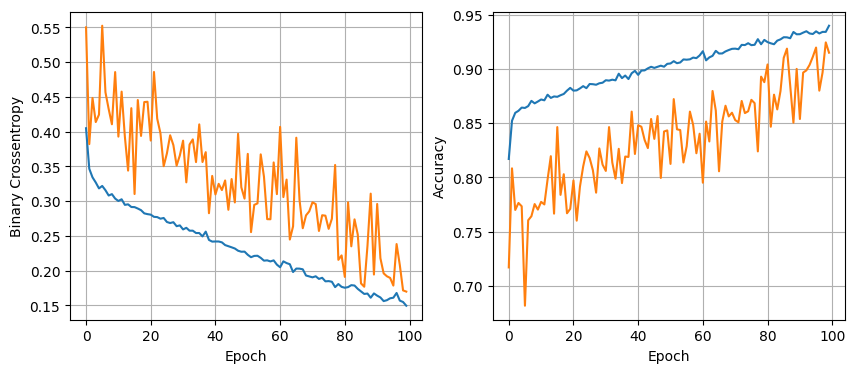

119/119 [==============================] - 0s 3ms/step - loss: 0.5853 - accuracy: 0.8428
64 nodes, dropout 0, lr 0.005, batchsize 32


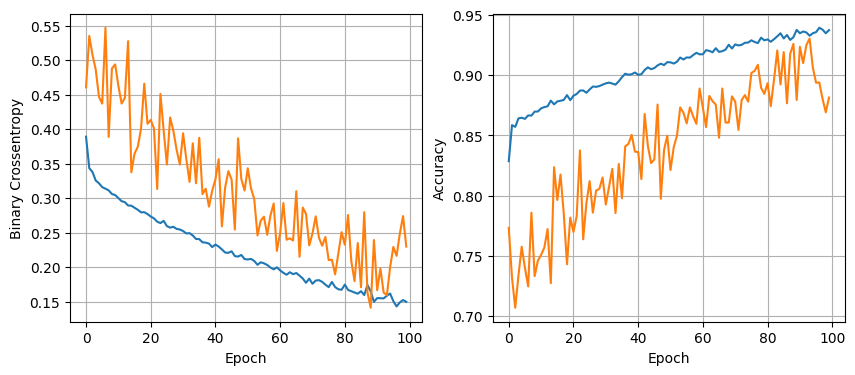

119/119 [==============================] - 0s 1ms/step - loss: 0.5585 - accuracy: 0.8544
64 nodes, dropout 0, lr 0.005, batchsize 64


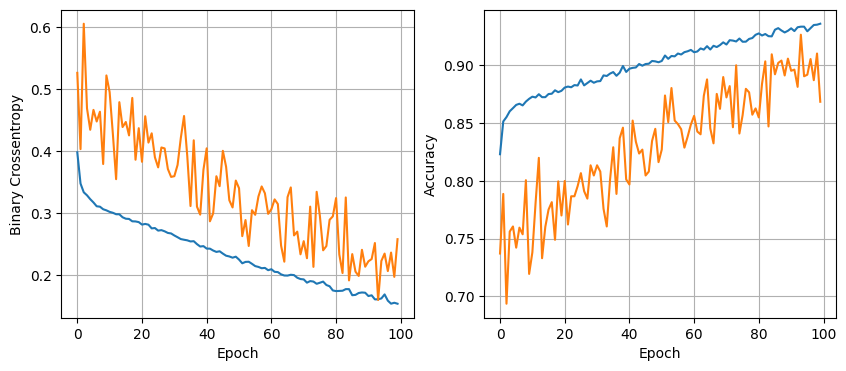

119/119 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.8533
64 nodes, dropout 0, lr 0.005, batchsize 128


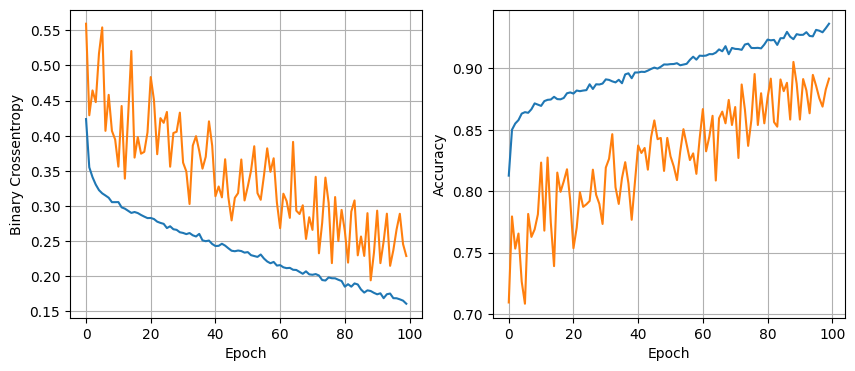

119/119 [==============================] - 0s 1ms/step - loss: 0.4791 - accuracy: 0.8428
64 nodes, dropout 0, lr 0.001, batchsize 32


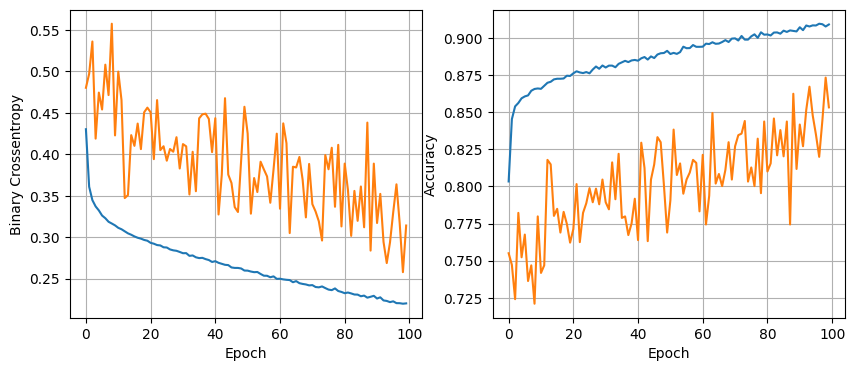

119/119 [==============================] - 0s 1ms/step - loss: 0.3421 - accuracy: 0.8680
64 nodes, dropout 0, lr 0.001, batchsize 64


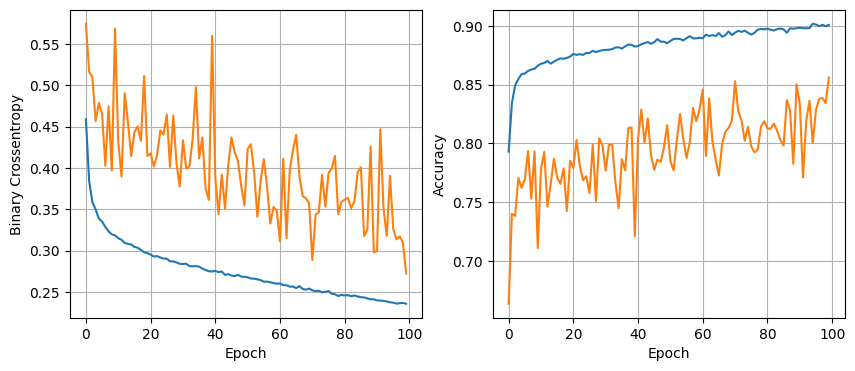

119/119 [==============================] - 0s 1ms/step - loss: 0.3474 - accuracy: 0.8549
64 nodes, dropout 0, lr 0.001, batchsize 128


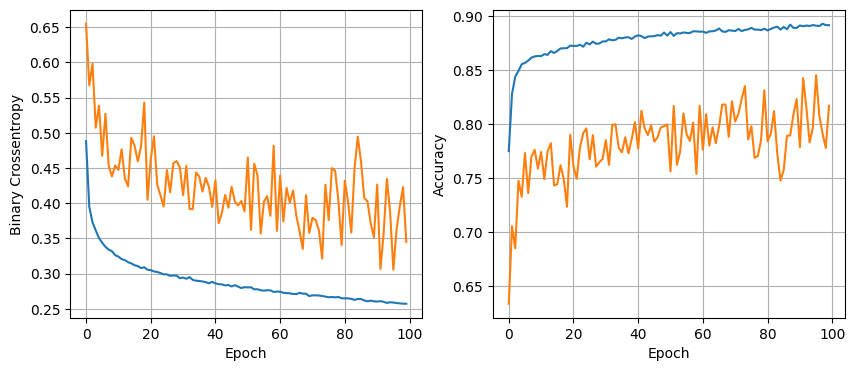

119/119 [==============================] - 0s 3ms/step - loss: 0.3240 - accuracy: 0.8644
64 nodes, dropout 0.2, lr 0.01, batchsize 32


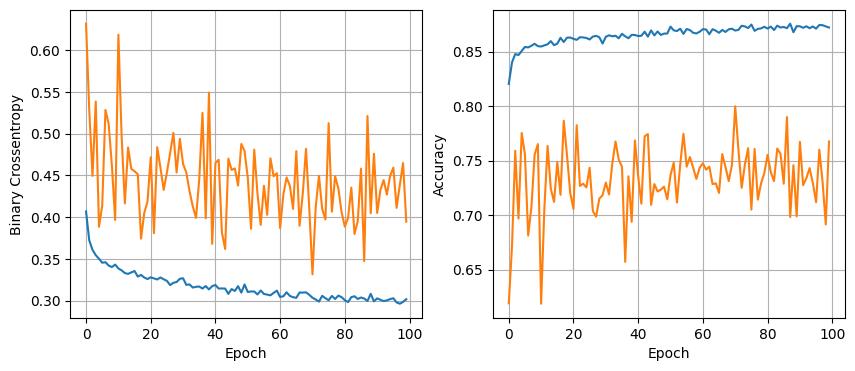

119/119 [==============================] - 0s 3ms/step - loss: 0.3126 - accuracy: 0.8704
64 nodes, dropout 0.2, lr 0.01, batchsize 64


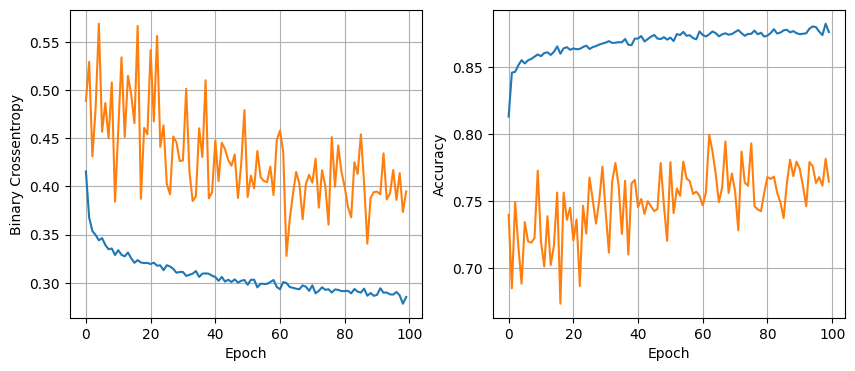

119/119 [==============================] - 0s 1ms/step - loss: 0.3077 - accuracy: 0.8746
64 nodes, dropout 0.2, lr 0.01, batchsize 128


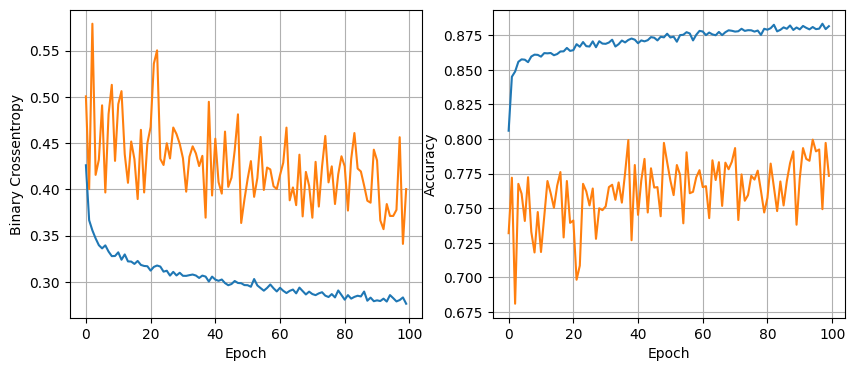

119/119 [==============================] - 0s 3ms/step - loss: 0.3082 - accuracy: 0.8720
64 nodes, dropout 0.2, lr 0.005, batchsize 32


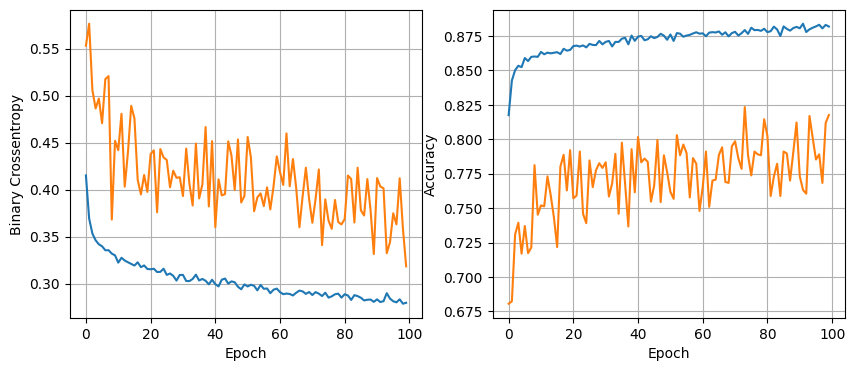

119/119 [==============================] - 0s 4ms/step - loss: 0.3201 - accuracy: 0.8717
64 nodes, dropout 0.2, lr 0.005, batchsize 64


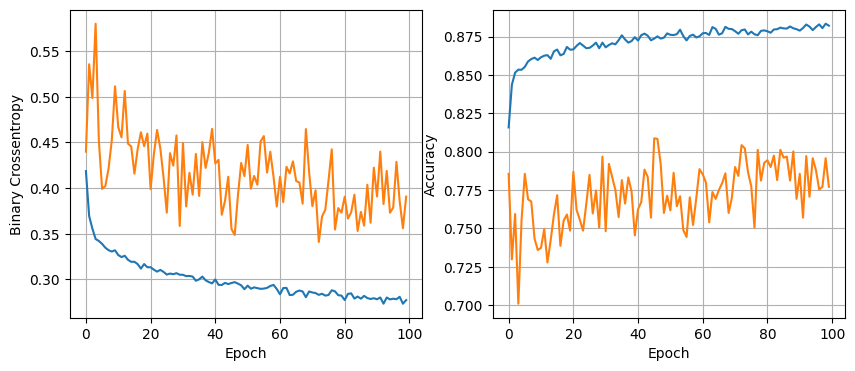

119/119 [==============================] - 0s 2ms/step - loss: 0.3019 - accuracy: 0.8770
64 nodes, dropout 0.2, lr 0.005, batchsize 128


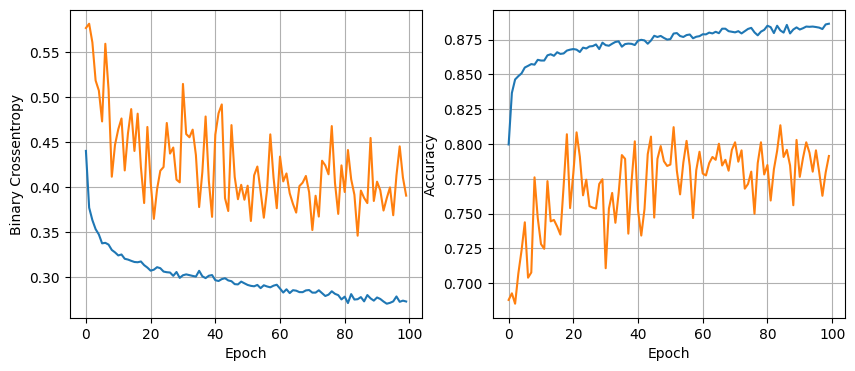

119/119 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.8725
64 nodes, dropout 0.2, lr 0.001, batchsize 32


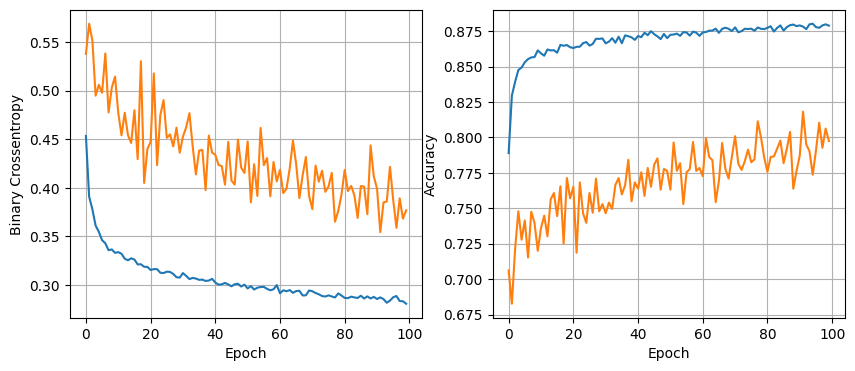

119/119 [==============================] - 0s 3ms/step - loss: 0.3024 - accuracy: 0.8749
64 nodes, dropout 0.2, lr 0.001, batchsize 64


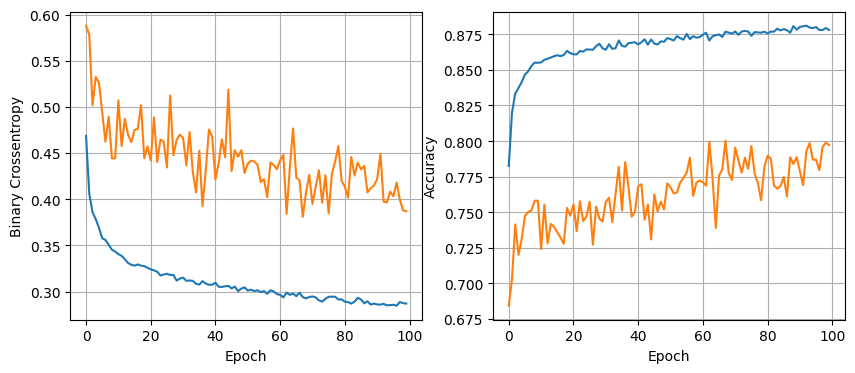

119/119 [==============================] - 1s 4ms/step - loss: 0.3004 - accuracy: 0.8746
64 nodes, dropout 0.2, lr 0.001, batchsize 128


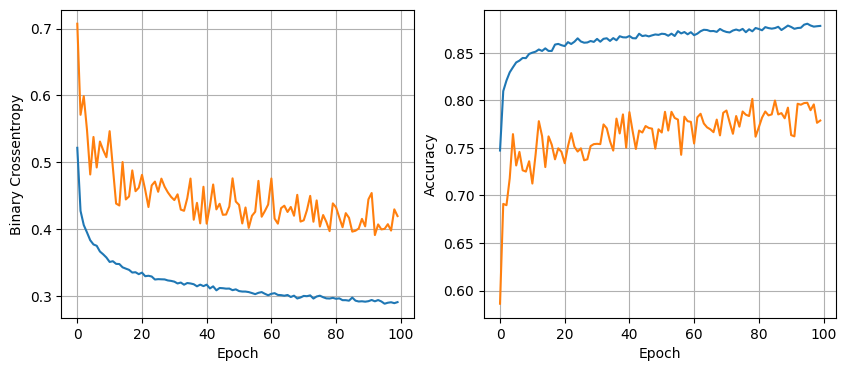

119/119 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.8733


In [55]:
least_val_loss = float('inf')
least_val_model = None
epochs = 100
for num_nodes in [16, 32, 64]:
    for dropout_prob in [0,0.2]:
        for lr in [0.01,0.005,0.001]:
            for batch_size in [32,64,128 ]:
                print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batchsize {batch_size}")
                model, history = train_model(X_train,y_train,num_nodes,dropout_prob,lr,batch_size,epochs)
                plot_history(history)
                val_loss = model.evaluate(X_valid,y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_val_model = model